In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: False


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [8]:
DATASET_PATH = "/content/drive/MyDrive/defect_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model.pth"


In [9]:
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 20
IMG_SIZE = 512

In [10]:
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
# First, make sure Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# List what's in your MyDrive
print("Contents of MyDrive:")
!ls "/content/drive/MyDrive/"

print("\n" + "="*50 + "\n")

# Search for the dataset folders
print("Searching for dataset folders...")
!find /content/drive/MyDrive/ -type d -name "*def*" -o -type d -name "*ok*" | head -20

Mounted at /content/drive
Contents of MyDrive:
'10th marksheet .pdf'
'4 WEEK Final Course List (July - Dec 2024) (1) (1).xlsx'
'4 WEEK Final Course List (July - Dec 2024) (1).xlsx'
 881037130744761_signed.pdf
'Aadhar back.pdf'
'AJP Microproject(22517).docx'
 Assignment-4.gdoc
 Assignment-6.gdoc
'Assignment: Full stack developer.gdoc'
 B400610333.pdf
 best_model.pth
'BODAKE VAISHANVI MADHAV_CC.jpg'
'BODAKE VAISHANVI MADHAV_DOM.jpg'
'BODAKE VAISHANVI MADHAV_IC_0001.jpg'
'BODAKE VAISHANVI MADHAV_IC_0002.jpg'
'BODAKE VAISHANVI MADHAV_NAT_0001.jpg'
'BODAKE VAISHANVI MADHAV_NAT_0002.jpg'
'BODAKE VAISHANVI MADHAV_PHOTO_SIGN (1).jpg'
'BODAKE VAISHANVI MADHAV_PHOTO_SIGN.jpg'
'BODAKE VAISHANVI MADHAV_SSC (1).jpg'
'BODAKE VAISHANVI MADHAV_SSC.jpg'
'BODKE VAISHANVI MADHAV_8TH_9TH.jpg'
'BODKE VAISHANVI MADHAV_9TH.jpg'
'BODKE VAISHANVI MADHAV_NCL.jpg'
 Classroom
'Colab Notebooks'
 Contacts-2022-12-11.vcf
 Contacts-2023-04-30.vcf
'Contacts-2023-07-12 (1).vcf'
 Contacts-2023-07-12.vcf
'Contacts-2023-0

In [13]:
print("Loading dataset...")
full_dataset = ImageFolder(root=DATASET_PATH, transform=train_transform)

# Print dataset info
print(f"Total images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Class to index mapping: {full_dataset.class_to_idx}")

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to validation set
val_dataset.dataset.transform = val_transform

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



Loading dataset...
Total images: 1300
Classes: ['def_front', 'ok_front']
Class to index mapping: {'def_front': 0, 'ok_front': 1}
Training images: 1040
Validation images: 260


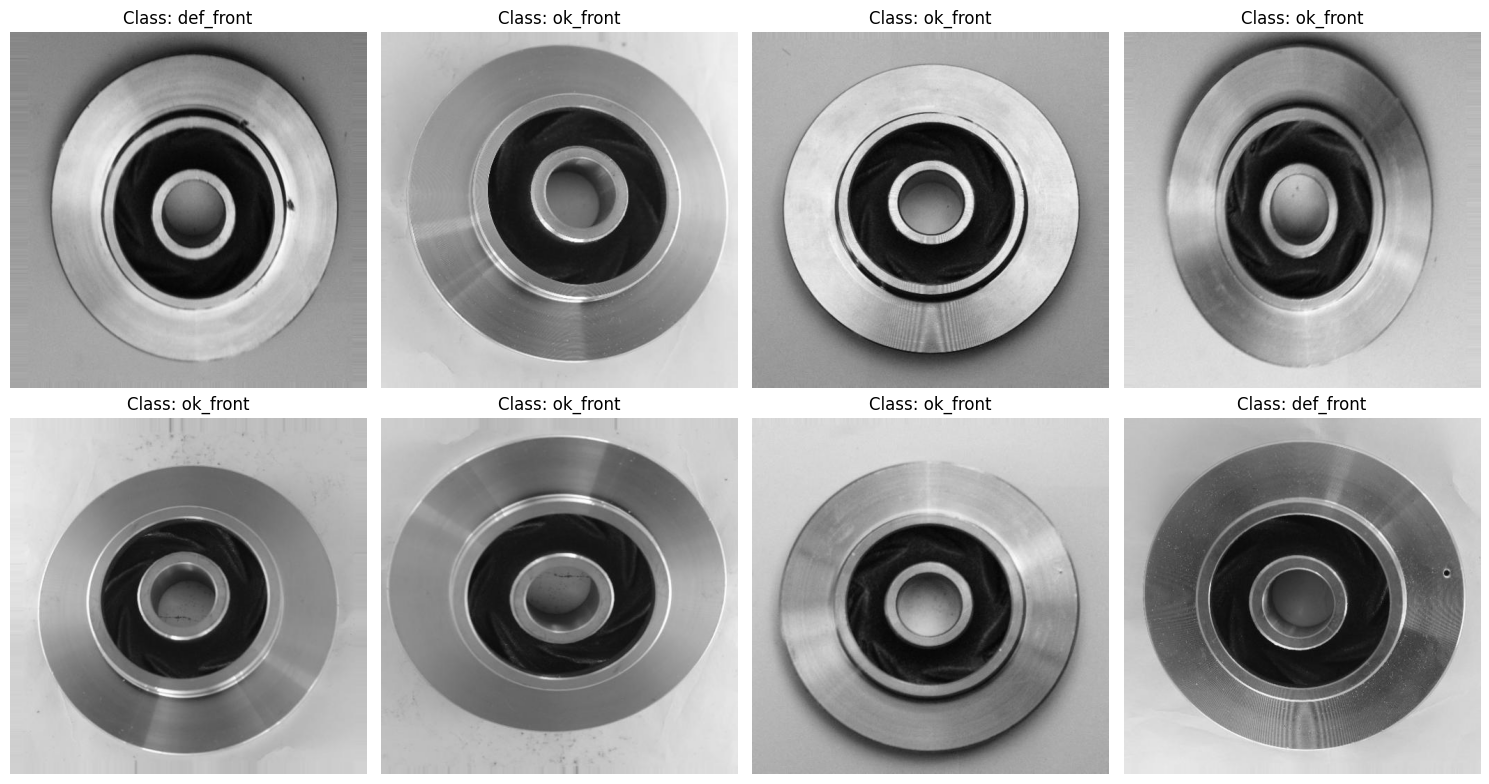

In [14]:
def show_samples(dataset, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {full_dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [15]:
class DefectClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DefectClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = DefectClassifier(num_classes=2).to(device)
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 62.6MB/s]


DefectClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': running_loss/total, 'acc': 100*correct/total})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [18]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': running_loss/total, 'acc': 100*correct/total})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [19]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✓ Model saved! Best validation accuracy: {best_val_acc:.2f}%")

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:25<00:00,  1.48s/it, loss=0.0168, acc=91.9]


Train Loss: 0.2548, Train Acc: 90.19%
Val Loss: 0.2572, Val Acc: 91.92%
✓ Model saved! Best validation accuracy: 91.92%

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.61it/s, loss=0.00878, acc=95]


Train Loss: 0.1220, Train Acc: 96.06%
Val Loss: 0.1342, Val Acc: 95.00%
✓ Model saved! Best validation accuracy: 95.00%

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s, loss=0.0148, acc=92.3]


Train Loss: 0.1240, Train Acc: 95.48%
Val Loss: 0.2268, Val Acc: 92.31%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s, loss=0.109, acc=72.7]


Train Loss: 0.0870, Train Acc: 96.92%
Val Loss: 1.6621, Val Acc: 72.69%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.41it/s, loss=0.00616, acc=96.9]


Train Loss: 0.0888, Train Acc: 97.12%
Val Loss: 0.0942, Val Acc: 96.92%
✓ Model saved! Best validation accuracy: 96.92%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.82it/s, loss=0.0037, acc=99.2]


Train Loss: 0.0669, Train Acc: 97.60%
Val Loss: 0.0566, Val Acc: 99.23%
✓ Model saved! Best validation accuracy: 99.23%

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.65it/s, loss=0.00166, acc=99.2]


Train Loss: 0.0328, Train Acc: 98.94%
Val Loss: 0.0253, Val Acc: 99.23%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.85it/s, loss=0.00195, acc=98.8]


Train Loss: 0.0299, Train Acc: 98.94%
Val Loss: 0.0297, Val Acc: 98.85%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.42it/s, loss=0.00473, acc=96.5]


Train Loss: 0.0369, Train Acc: 98.85%
Val Loss: 0.0723, Val Acc: 96.54%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s, loss=0.000628, acc=99.6]


Train Loss: 0.0233, Train Acc: 99.33%
Val Loss: 0.0096, Val Acc: 99.62%
✓ Model saved! Best validation accuracy: 99.62%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  5.79it/s, loss=0.00136, acc=98.8]


Train Loss: 0.0100, Train Acc: 99.81%
Val Loss: 0.0208, Val Acc: 98.85%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.40it/s, loss=0.00459, acc=96.9]


Train Loss: 0.0444, Train Acc: 98.75%
Val Loss: 0.0703, Val Acc: 96.92%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  5.75it/s, loss=0.00691, acc=96.5]


Train Loss: 0.0712, Train Acc: 97.40%
Val Loss: 0.1058, Val Acc: 96.54%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.20it/s, loss=0.00305, acc=98.5]


Train Loss: 0.0835, Train Acc: 97.02%
Val Loss: 0.0466, Val Acc: 98.46%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.89it/s, loss=0.00167, acc=99.2]


Train Loss: 0.0171, Train Acc: 99.52%
Val Loss: 0.0255, Val Acc: 99.23%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  5.76it/s, loss=0.000926, acc=99.2]


Train Loss: 0.0060, Train Acc: 99.81%
Val Loss: 0.0142, Val Acc: 99.23%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s, loss=0.00109, acc=99.2]


Train Loss: 0.0055, Train Acc: 99.81%
Val Loss: 0.0166, Val Acc: 99.23%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.25it/s, loss=0.000996, acc=99.2]


Train Loss: 0.0025, Train Acc: 100.00%
Val Loss: 0.0152, Val Acc: 99.23%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, loss=0.000605, acc=99.6]


Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.0093, Val Acc: 99.62%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 17/17 [00:02<00:00,  6.42it/s, loss=0.000389, acc=99.6]

Train Loss: 0.0086, Train Acc: 99.71%
Val Loss: 0.0060, Val Acc: 99.62%

Training completed!
Best validation accuracy: 99.62%


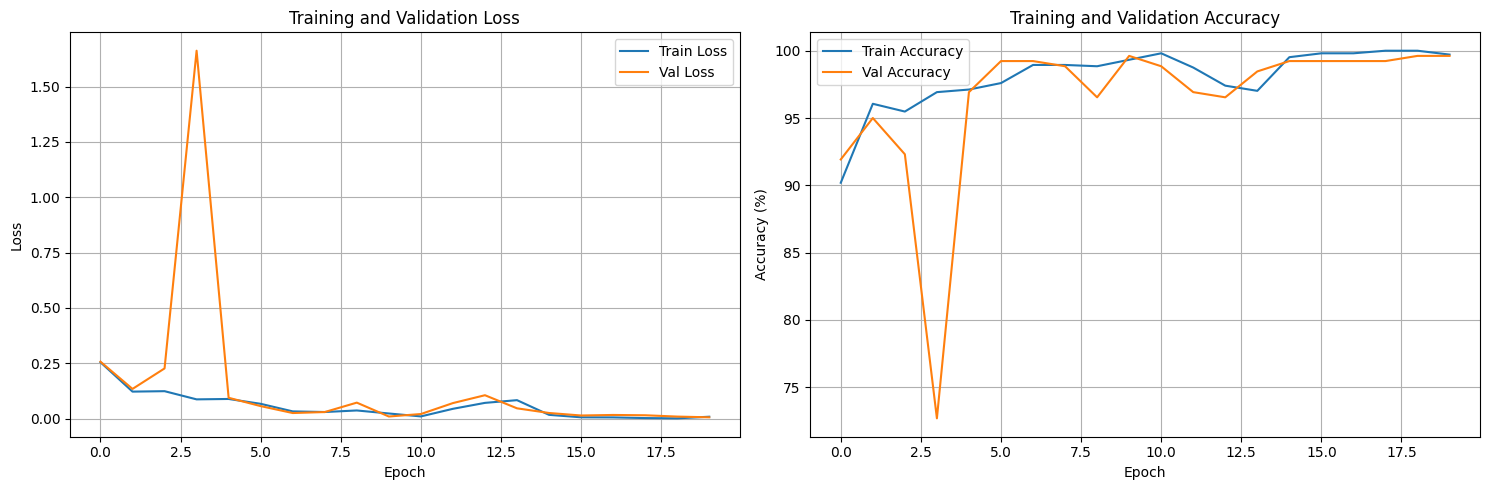

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Testing model on sample images...


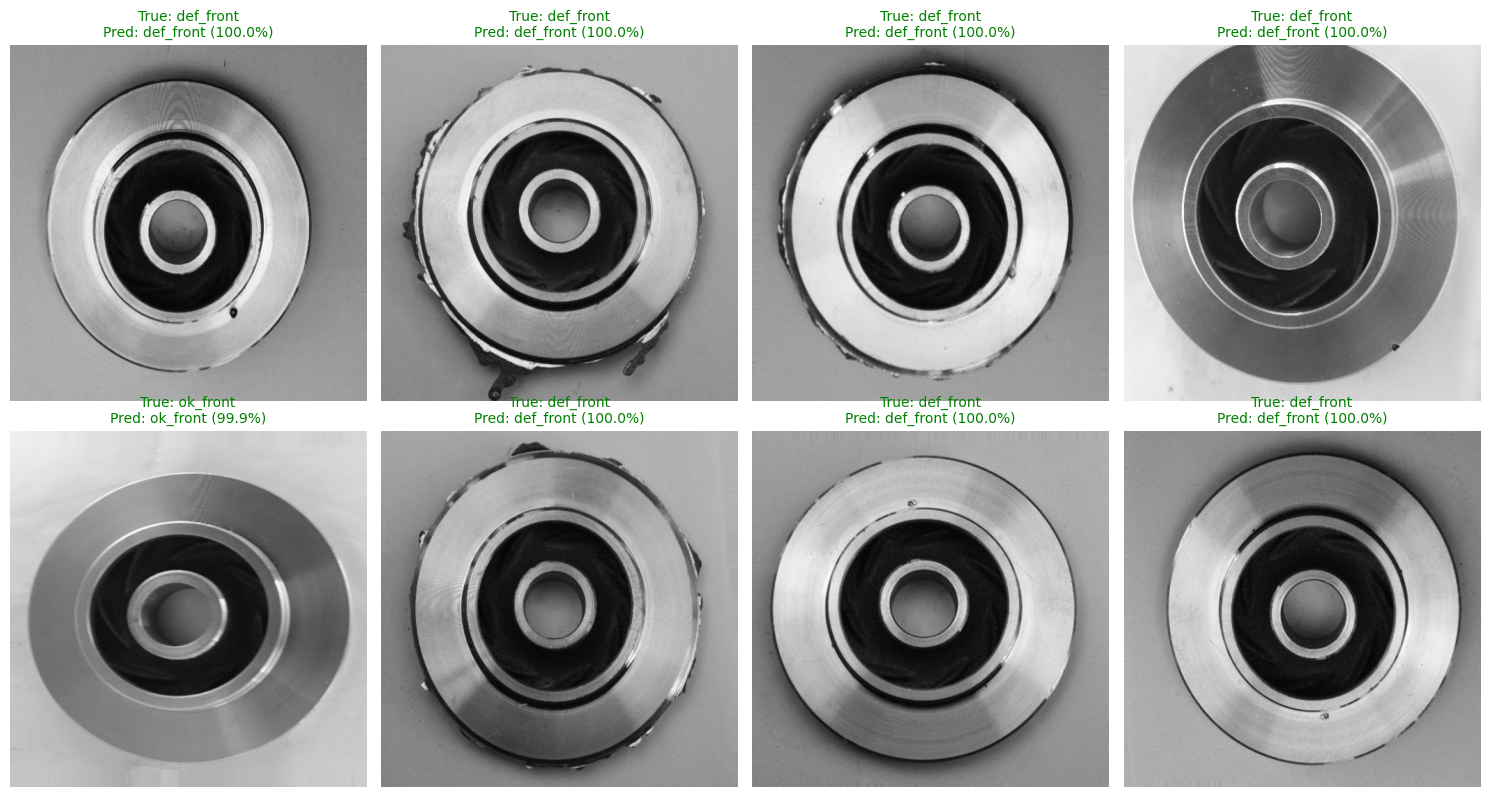


Model saved at: /content/drive/MyDrive/best_model.pth
You can now use this model in your Gradio app!


In [22]:

# CELL 14: Test the Model
print("\nTesting model on sample images...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    img, label = val_dataset[i]
    img_display = img.permute(1, 2, 0).numpy()
    img_display = (img_display * 0.5) + 0.5
    img_display = np.clip(img_display, 0, 1)

    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, predicted = torch.max(output, 1)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]

    true_label = full_dataset.classes[label]
    pred_label = full_dataset.classes[predicted.item()]
    confidence = probs[predicted.item()] * 100

    color = 'green' if predicted.item() == label else 'red'

    axes[i].imshow(img_display)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
                      color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\nModel saved at: {MODEL_SAVE_PATH}")
print("You can now use this model in your Gradio app!")

In [ ]:
# Install Gradio if not already installed
!pip install gradio -q

import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
import cv2
from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define the same model architecture used in training
class DefectClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DefectClassifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load the trained model
MODEL_PATH = "/content/drive/MyDrive/best_model.pth"
print(f"Loading model from: {MODEL_PATH}")

model = DefectClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded successfully!")

# Define transforms (same as validation transforms)
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Class names - UPDATE THESE based on your dataset
CLASS_NAMES = ["Defective", "Non-Defective"]  # Adjust order if needed

def predict_image(img):
    """
    Predict whether an image shows a defect or not
    """
    if img is None:
        return "Please upload an image", None, None

    try:
        # Convert to PIL Image if needed
        if isinstance(img, np.ndarray):
            image = Image.fromarray(img).convert("RGB")
        else:
            image = img.convert("RGB")

        # Transform image
        img_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]
            predicted_class = np.argmax(probabilities)
            confidence = probabilities[predicted_class]

        # Get class name and create result
        class_name = CLASS_NAMES[predicted_class]
        result_text = f"{class_name}"
        confidence_text = f"Confidence: {confidence*100:.2f}%"

        # Create confidence dictionary for all classes
        confidence_dict = {CLASS_NAMES[i]: float(probabilities[i]) for i in range(len(CLASS_NAMES))}

        return result_text, confidence_text, confidence_dict

    except Exception as e:
        return f"Error: {str(e)}", None, None

# Create Gradio interface
with gr.Blocks(title="Defect Detection System") as demo:
    gr.Markdown(
        """
        # 🔍 Defect Detection System
        Upload an image to detect defects using AI.
        """
    )

    with gr.Row():
        with gr.Column():
            input_image = gr.Image(type="numpy", label="Upload Image")
            predict_btn = gr.Button("Analyze Image", variant="primary")

        with gr.Column():
            result_label = gr.Textbox(label="Prediction", interactive=False)
            confidence_label = gr.Textbox(label="Confidence Score", interactive=False)
            confidence_plot = gr.Label(label="Class Probabilities")

    # Examples (optional - add paths to sample images if you have them)
    gr.Markdown("### 💡 Tips for best results:")
    gr.Markdown("- Use clear, well-lit images")
    gr.Markdown("- Ensure the object is centered in the frame")
    gr.Markdown("- Avoid blurry or low-resolution images")

    # Set up the prediction
    predict_btn.click(
        fn=predict_image,
        inputs=input_image,
        outputs=[result_label, confidence_label, confidence_plot]
    )

# Launch the app
print("\nLaunching Gradio app...")
demo.launch(share=True, debug=True)

Using device: cuda
Loading model from: /content/drive/MyDrive/best_model.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!

Launching Gradio app...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ed2f49d545fa135313.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",